# Showcase Notebook project Agros - part 1

In [29]:
from agros import Agros

The class and methods developed with the Agricultural Output Productivity dataset have allowed us to extract valuable insights. The development of the task and the study of the agricultural outputs of several countries will help to contribute to the green transition by having a more savvy taskforce. The main insights are summarized below.

**1) Gapminder Plot 2019**

The graph below shows the relationship between total output quantity and fertilizer quantity for the most recent year (2019), plotted on a log scale. As can be deduced from the graph the total output quantity is positively correlated with fertilizer quantity: high amounts of fertilizer are associated with larger output quantities.

However, following the area of the dots (representing the TFP (total factor productivity), it can be established that the increase in total output quantity is not proportionate to the increase in fertilizer quantity. Namely, the larger the fertilizer quantity the smaller the areas of the dots (i.e. TFP). Specifically, a smaller TFP indicates that the total output is growing slower than the total inputs (including fertilizer). In other words: for countries with larger fertilizer quantities the total producitivyt of production decreases.

Data file already exists, skipping download...


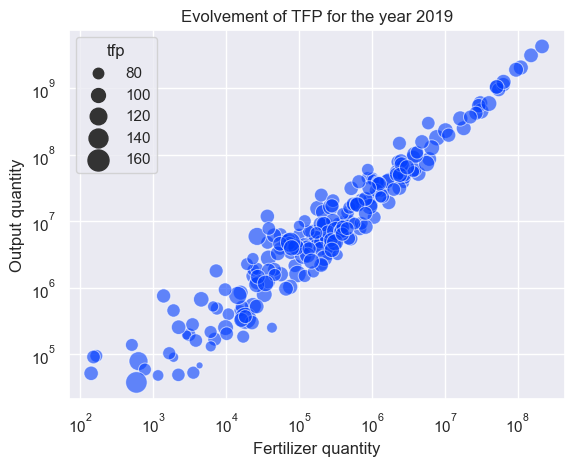

In [30]:
agros = Agros()
agros.gapminder(2019)

**2) Comparing three random countries (Brazil, Portugal, Afghanistan)**

Three random countries in the dataset (one from each continent) were selected to ilustrate and point out the main differences from our analysis. 

First, the fourth method was created to plots the crop, animal and fish outputs for a given country. Below, the comparison of the three outputs for Brazil, Portugal and Afghanistan are visualized. The main similarity betweeen the three countries is that they all have a minimal insignificant fish_output_quantity. Moreover, the crop and animal output quantity for the three countries follow a similar trend through time. That is to say, when crop outuput increases, so does the animal output for a given country and viceversa. 

The main differences that can be spotted are that each country follows different outputs trough time. Portugal shows a more constant production whereas Afghansitan and Brazil show a more gradual increase through time.

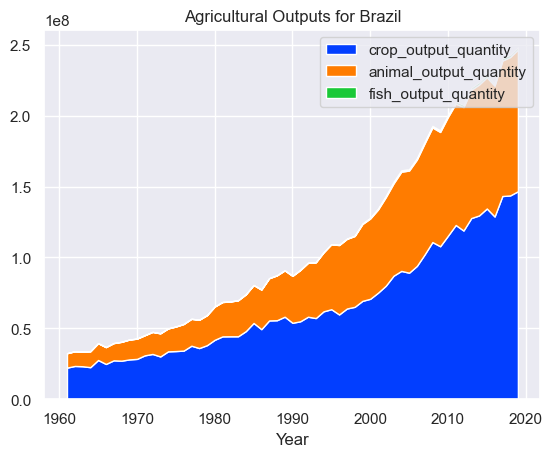

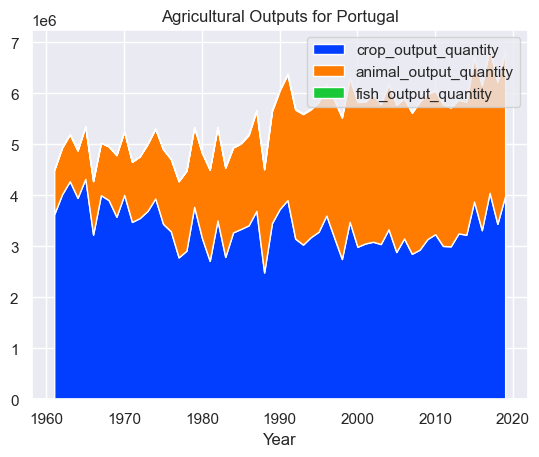

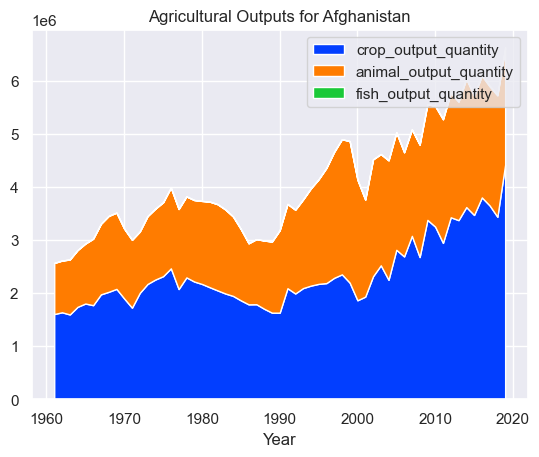

In [31]:
three_countries=["Brazil","Portugal","Afghanistan"]

for i in range(0,len(three_countries)):
    agros.areachart_country_output(three_countries[i])
    i=i+1

Additionally, the fifth method was used to illustrate the compare of total output for Brazil, Portugal and Afghanistan for each Year. As can be portrayed in the graph below, the three countries have reached similar output quantity level throughout the last decade. However, from 1960-2010, the european country, Portugal, has had a clear advantage over Brazil and Afghanistan. The evolution of output production from Portugal has been more steady and gradual. On the contrary, Brazil has vastly increased its output througout the years analysed and has had a constant increase. In the case of Afghanistan, the country shows the highest agricultural output for the last decade. The method carried out is very useful to compare different countries outputs throghout time and obtain useful insights. 

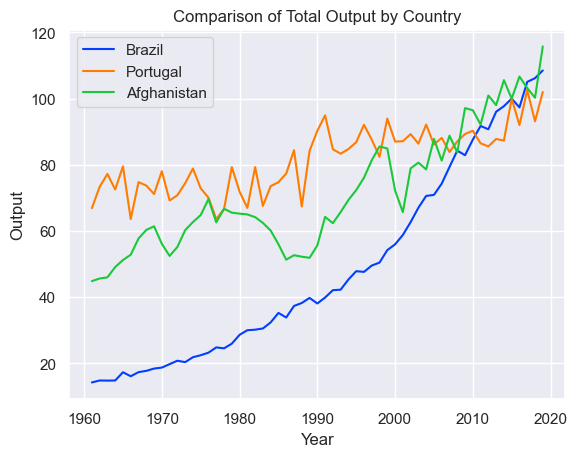

In [32]:
agros.plot_country_output(three_countries)

Finally, the third method developed shows a correlation plot that allows us to visualize how variables correlate with each other. As can be visualized below, all variables have a strong correlation wih eachother, all above 0.5. The only variables that have a weaker correlation with the other variables are the fish_output_quantity and the labor_output_quantity.

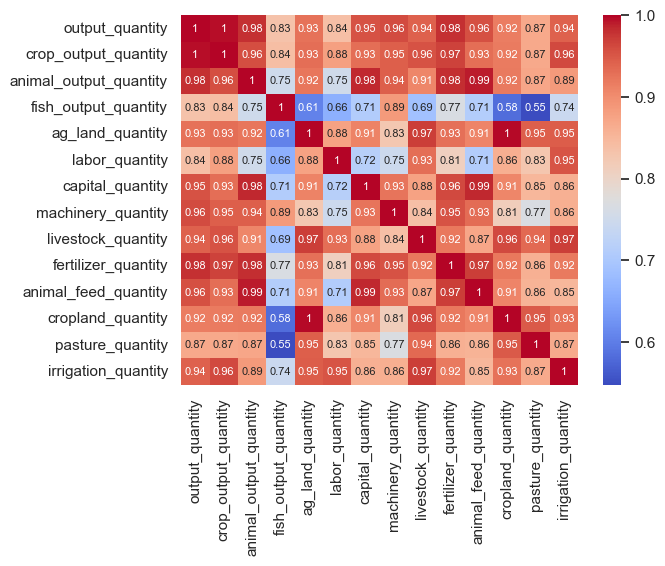

In [33]:
agros.plot_correlation()

**3) Final reflection on output and quantities**

Overall, the class and methods created for the analysis of Agricultural outputs between countries has allowed us to obtain valuable insights between quantities and outputs to contribute to the green transition in Agricultural production.

Specifically, low values for total factor productivity (TFP) for countries that use vast amounts of fertilizer show that the use of fertilizers is unsustainable on both an environmental and economic level. With respect to the former, by exhausting crucial resources fertilizers deplete the soil, causing harm to natural ecosystems globally. With respect to the latter, the use of fertilizers is not profitable because a depleted soil yields less output. Therefore, these analyses are crucial because they constitute an economic incentive for farmers and governmental institutions to accelearte the shift to sustainable agricultural production. 